In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.special import gammainc

from src.hbtp.HBTReader import HBTReader
from src import read
from src import cosmology
from src import nfw
# from src import einasto

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

### Analysis parameters

In [3]:
snap = 93
nbins = 10
bin = 7
r = HBTReader("./data/")

### Subhalo mass function

In [4]:
ss = r.LoadSubhalos(snap)
ss = ss[(ss['HostHaloId'] != -1) & (ss['BoundM200Crit'] > 0.0)& (ss['Nbound'] >= 20)]

counts, bin_edges = np.histogram(np.log10(ss['Nbound']), 20)
ss = np.lib.recfunctions.append_fields(ss, 'bin',\
    np.digitize(np.log10(ss['BoundM200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[31349 28610 23063 17260 11370  7387  4511  2864  1759  1073   622   395
   233   128    70    40    22    14     3     7] [ 1.30103     1.53095363  1.76087726  1.99080089  2.22072452  2.45064815
  2.68057178  2.91049541  3.14041904  3.37034267  3.6002663   3.83018993
  4.06011356  4.29003719  4.51996082  4.74988445  4.97980808  5.20973171
  5.43965534  5.66957897  5.8995026 ] [ 1.41599181  1.64591544  1.87583907  2.1057627   2.33568633  2.56560996
  2.79553359  3.02545722  3.25538085  3.48530448  3.71522811  3.94515174
  4.17507537  4.404999    4.63492263  4.86484626  5.09476989  5.32469352
  5.55461715  5.78454078]


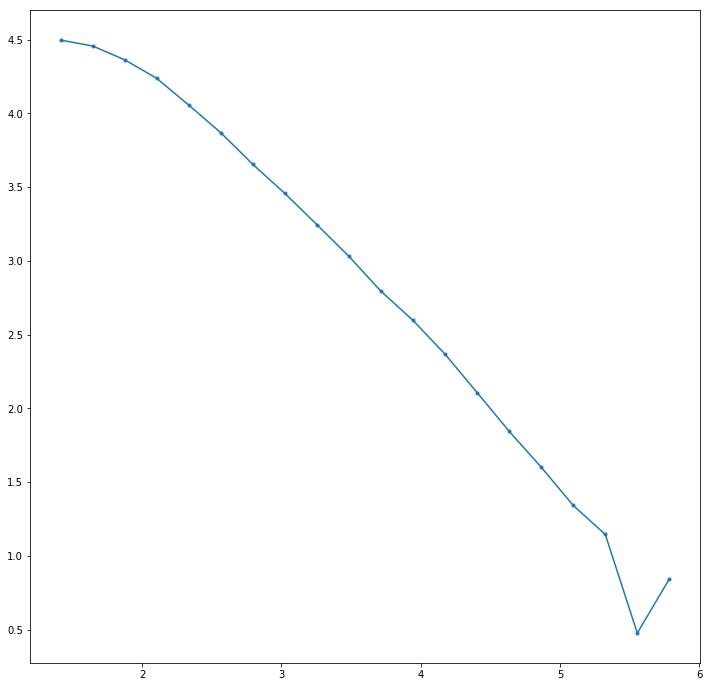

In [5]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')

### Halo mass function

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [6]:
hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit']]
hs = hs[hs['M200Crit'] >= 20]
hs['M200Crit'] = 1e10*hs['M200Crit']

counts, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = np.lib.recfunctions.append_fields(hs, 'bin',\
    np.digitize(np.log10(hs['M200Crit']), bin_edges),\
    usemask=False)
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
print counts, bin_edges, bins

[1592  902  501  268  151   81   35   19    6    7] [ 11.3013382   11.5803916   11.859445    12.1384984   12.4175518
  12.69660521  12.97565861  13.25471201  13.53376541  13.81281881
  14.09187222] [ 11.4408649   11.7199183   11.9989717   12.2780251   12.5570785
  12.83613191  13.11518531  13.39423871  13.67329211  13.95234551]


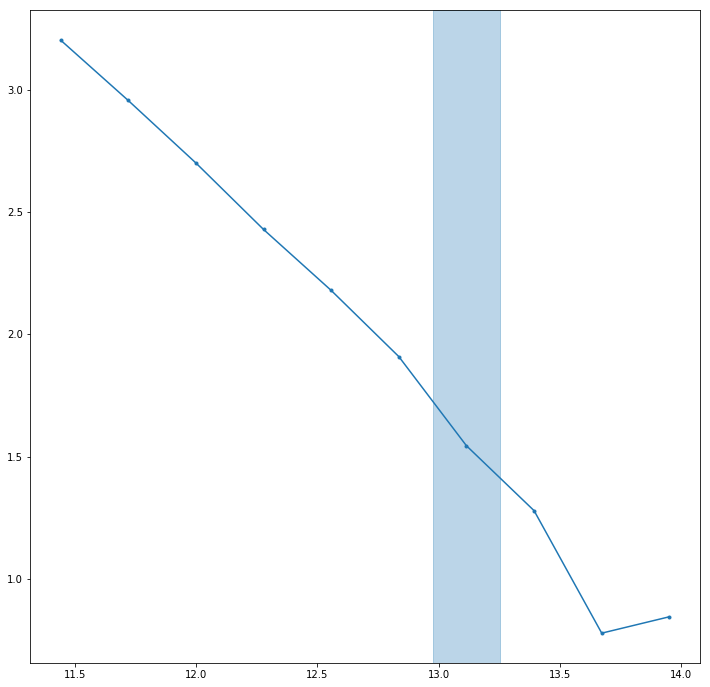

In [7]:
plt.plot(bins, np.log10(counts), color='C0', marker='.')
plt.axvspan(bin_edges[bin-1], bin_edges[bin], color='C0', alpha=0.3)

In [8]:
hs = hs[hs['bin'] == bin]

### Density profile

In [9]:
ps = np.array(r.LoadHostHalos(snap, [list(hs['HaloId']),])['Profile'],\
    dtype=np.float)
xmin = 0.5*np.cbrt((4.0*np.pi)/(3.0*np.sum(np.mean(ps, axis=0))))
ps = np.divide(ps.T, np.sum(ps, axis=1)).T
p = np.mean(ps, axis=0)
x = np.linspace(-2.0, 0.0, 20)
# vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))

In [10]:
xmax = 0.8
idx = np.where((np.power(10,x) < xmax) & (np.power(10,x) > xmin))
c = nfw.fit(p, lambda c: nfw.m(np.power(10.0,x), c), np.linspace(1.0, 10.0, 100))
rho_s = np.log10(nfw.rho_enc(1.0/c, c))

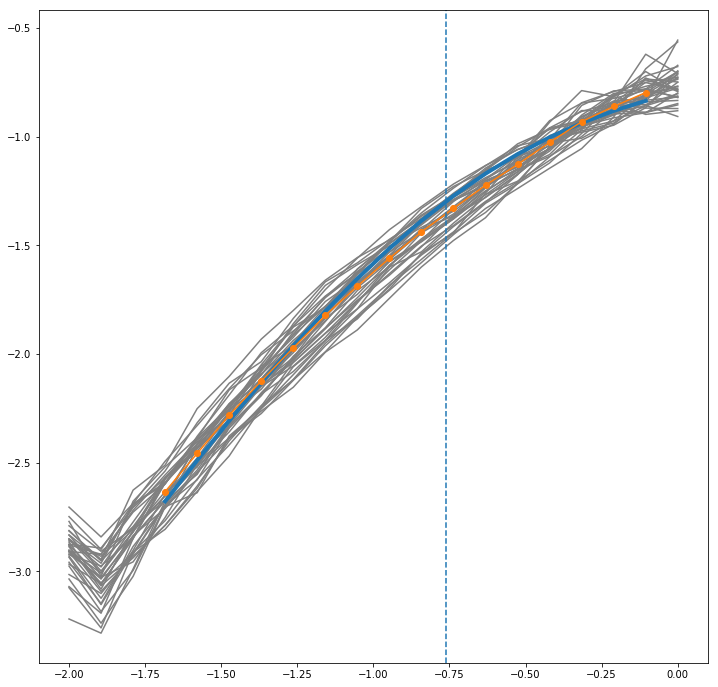

In [11]:
# plt.fill_between(x,\
#     np.log10(nfw.m_diff(np.power(10.,x), c_err[0])),\
#     np.log10(nfw.m_diff(np.power(10.,x), c_err[1])),
#     color='C0', alpha=0.2, zorder=1)
plt.plot(x[idx], np.log10(nfw.m(np.power(10.,x), c)[idx]),\
    color='C0', linewidth=4, zorder=1)

[plt.plot(x, np.log10(_), color='grey', zorder=0) for _ in ps]
plt.plot(x[idx], np.log10(p[idx]), color='C1', marker='o', zorder=2)
plt.axvline(np.log10(1.0/c), color='C0', linestyle='--')

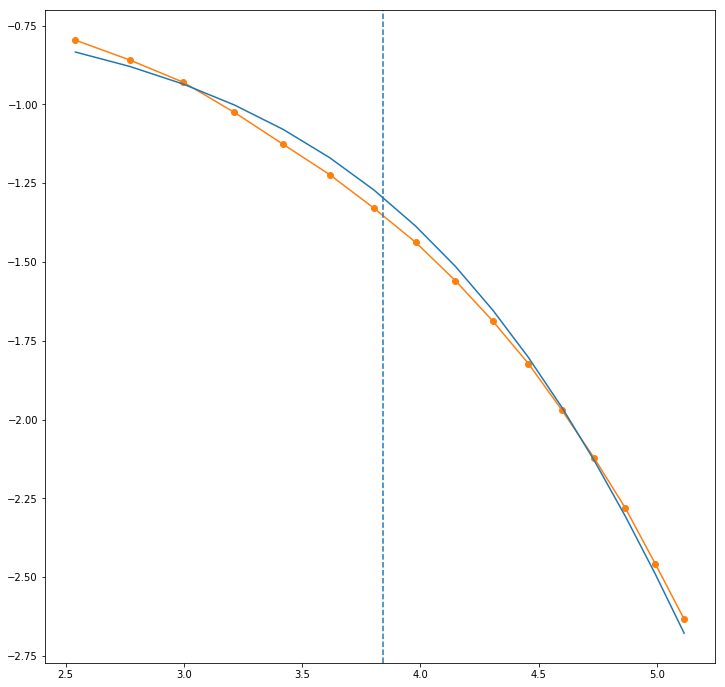

In [12]:
plt.plot(np.log10(nfw.rho_enc(np.power(10.,x), c)[idx]), np.log10(p[idx]),\
    color='C1', marker='o')
plt.plot(np.log10(nfw.rho_enc(np.power(10.,x), c)[idx]), np.log10(nfw.m(np.power(10.,x), c)[idx]),\
    color='C0')
plt.axvline(rho_s, color='C0', linestyle='--')

### Collapsed Mass History

In [13]:
F = nfw.Y(1.0)/nfw.Y(c)

In [14]:
ms = np.array(read.cmh(snap).loc[hs['HaloId']], dtype=np.float)
ms = np.divide(ms.T, ms[:,-1]).T
m = np.mean(ms, axis=0)

zs = np.genfromtxt('./output/hbtp/redshift_list.txt',\
    dtype=np.dtype([('snapshot',np.int32), ('redshift',np.float32)]))
rho = cosmology.rho_c(\
    np.array([zs[zs['snapshot'] == s][0]['redshift']\
    for s in np.arange(1+snap-ms.shape[1], 1+snap)]))\
    / cosmology.rho_c(zs[zs['snapshot'] == snap][0]['redshift'])

In [15]:
m_f = F*m[-1]
y1, y2 = m[m > m_f][0], m[m < m_f][-1]
x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
rho_f = (np.log10(x1/x2)/np.log10(y1/y2))*(np.log10(m_f/y1))+np.log10(x1)

/cosma/home/dp004/dc-oles1/merger_trees/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/cosma/home/dp004/dc-oles1/merger_trees/env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


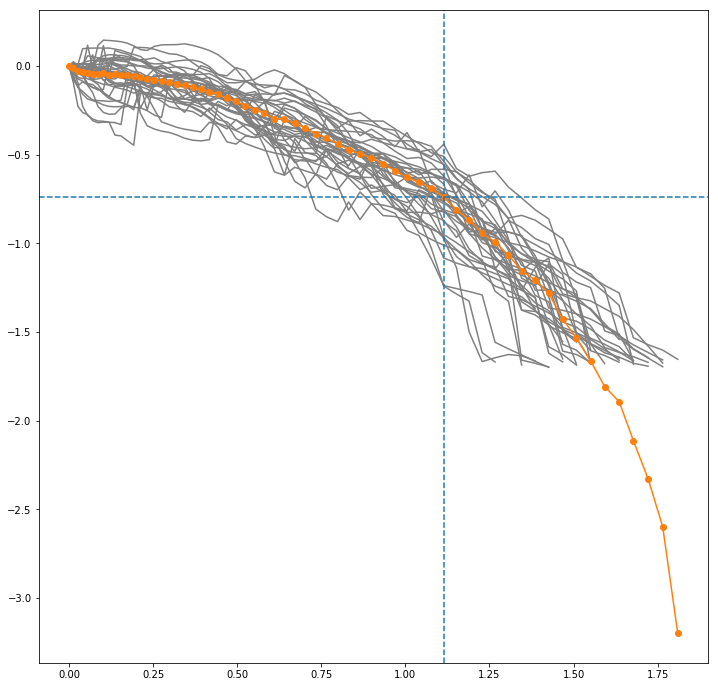

In [16]:
[plt.plot(np.log10(rho), np.log10(_), color='grey') for _ in ms]
plt.plot(np.log10(rho), np.log10(m),\
    color='C1', marker='o')
plt.axhline(np.log10(m_f), color='C0', linestyle='--')
plt.axvline(rho_f, color='C0', linestyle='--')

In [17]:
rho_f, rho_s

(1.1138839032754198, 3.842743500040724)

In [25]:
def einasto_m_enc(x, c, a):
    return np.divide(\
        gammainc(3.0/a, (2.0/a)*np.power(c*x, a)),
        gammainc(3.0/a, (2.0/a)*np.power(c, a)))
def einasto_m(x, c, a):
    y = einasto_m_enc(x, c, a)
    y[1:] = np.diff(einasto_m_enc(x, c, a))
    return y

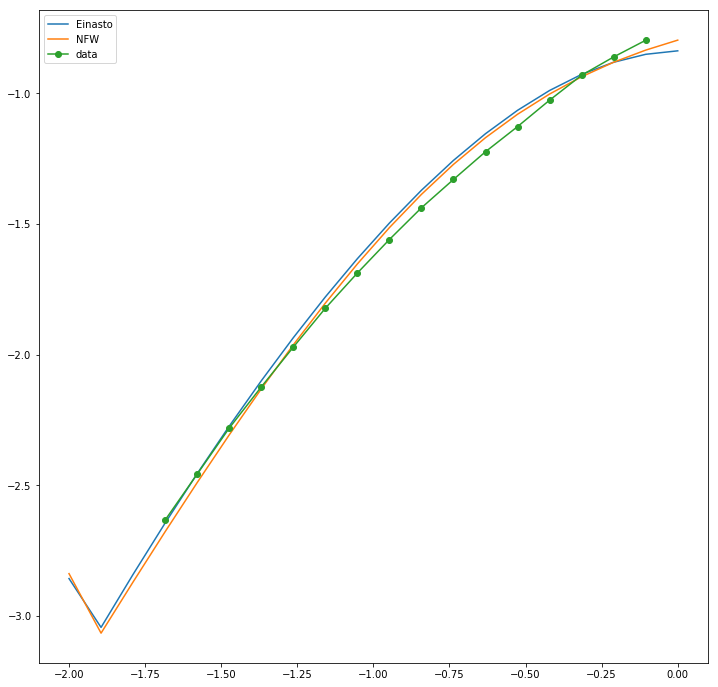

In [48]:
a = 0.24
plt.plot(x,\
    np.log10(einasto_m(np.power(10.0, x), c, a)),\
    label='Einasto')
plt.plot(x,\
    np.log10(nfw.m(np.power(10.0, x), c)),
    label='NFW')
plt.plot(x[idx],\
    np.log10(p[idx]),\
    marker='o', label='data')
plt.legend()

### Density - density relation

After the analysis above has been done for all mass bins, for all snapshots, we can start plotting the density - density relation. Below are test results from 

In [19]:
ds = np.genfromtxt('./output/hbtp/rhof_rhos.csv', delimiter=',', dtype=np.dtype([\
    ('snap',int),\
    ('bin',int),\
    ('rho_f',float),\
    ('rho_s',float),\
]))
# ds = ds[ds['snap'] == snap]

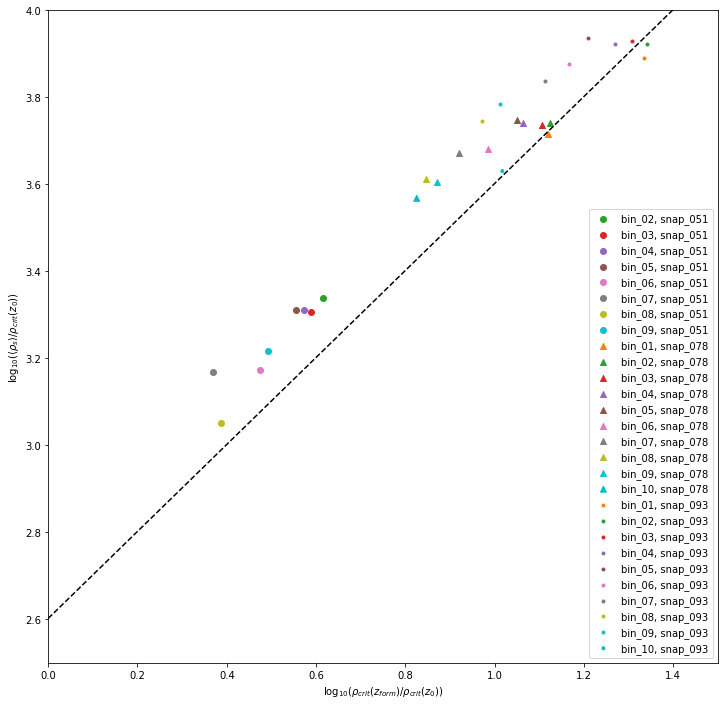

In [20]:
for d in ds[ds['snap'] == 51]:
    plt.scatter(d['rho_f'], d['rho_s'],\
        color='C%d'%d['bin'], marker='o',\
#         label='%.2f...%.2f'%(bin_edges[int(d['bin'])-1],bin_edges[int(d['bin'])]))
        label='bin_%02d, snap_051'%(int(d['bin'])))
for d in ds[ds['snap'] == 78]:
    plt.scatter(d['rho_f'], d['rho_s'],\
        color='C%d'%d['bin'], marker='^',\
        label='bin_%02d, snap_078'%(int(d['bin'])))
for d in ds[ds['snap'] == 93]:
    plt.scatter(d['rho_f'], d['rho_s'],\
        color='C%d'%d['bin'], marker='.',\
#         label='%.2f...%.2f'%(bin_edges[int(d['bin'])-1],bin_edges[int(d['bin'])]))
        label='bin_%02d, snap_093'%(int(d['bin'])))
plt.plot(np.linspace(0.0, 1.5), np.log10(400)+np.linspace(0.0, 1.5), 'k--')

plt.xlabel(r'$\log_{10}(\rho_{crit}(z_{form})/\rho_{crit}(z_0))$')
plt.ylabel(r'$\log_{10}(\langle\rho_{s}\rangle/\rho_{crit}(z_0))$')
plt.xlim((0.0, 1.5))
plt.ylim((2.5,4.0))
plt.legend(loc='lower right')